In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec
from models import CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier, TClassifier
from training_function import training
from config_dataset import custom_dataset
from accuracy import classifier_accuracy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sequence_length = 20
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [4]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('text_corpus/divina_commedia.txt',
                                                                                                                                                        'text_corpus/uno_nessuno_e_i_malavoglia.txt',
                                                                                                                                                        'text_corpus/lo_cunto_de_li_cunti.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  633
len val loader:  80
total number of training samples:  20246
total number of validation samples:  2529
vocab size:  26606


# CNN Classifier

In [6]:
cnn_classifier = CNNClassifier(embedding_matrix, 3, 3, [3,3,3])

In [7]:
classifier_params = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8139


 12%|█▎        | 1/8 [00:02<00:18,  2.67s/it]

====> Epoch: 1 Average train loss: 0.0197, Average val loss: 0.0181


 25%|██▌       | 2/8 [00:05<00:15,  2.67s/it]

====> Epoch: 2 Average train loss: 0.0178, Average val loss: 0.0180


 38%|███▊      | 3/8 [00:08<00:13,  2.77s/it]

====> Epoch: 3 Average train loss: 0.0176, Average val loss: 0.0179


 50%|█████     | 4/8 [00:10<00:10,  2.65s/it]

====> Epoch: 4 Average train loss: 0.0175, Average val loss: 0.0179


 62%|██████▎   | 5/8 [00:13<00:07,  2.62s/it]

====> Epoch: 5 Average train loss: 0.0174, Average val loss: 0.0179


 75%|███████▌  | 6/8 [00:16<00:05,  2.68s/it]

====> Epoch: 6 Average train loss: 0.0174, Average val loss: 0.0179


 88%|████████▊ | 7/8 [00:18<00:02,  2.64s/it]

====> Epoch: 7 Average train loss: 0.0173, Average val loss: 0.0179


100%|██████████| 8/8 [00:21<00:00,  2.65s/it]

====> Epoch: 8 Average train loss: 0.0173, Average val loss: 0.0179


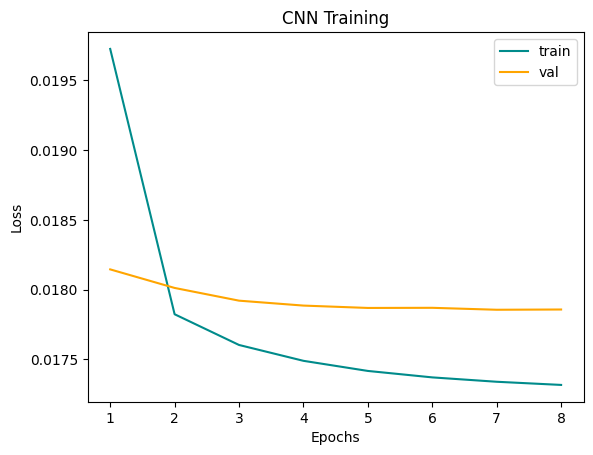

In [8]:
train_losses = training(cnn_classifier, train_loader, val_loader, 8, 4e-4, 'CNN Training')

### Examples with CNN 

In [9]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = cnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  57.61169195175171 %
Input sequence: 
 que flailli ch avieno spirto sol di pensier santi poscia che i cari e lucidi lapilli ond io vidi ingemmato


# CNN Classifier Accuracy

In [10]:
classifier_accuracy(cnn_classifier, style0_test, style1_test, style2_test, 'CNN')

Accuracy predicting Dante:  0.9813176007866273
Accuracy predicting Italian:  0.992133726647001
Accuracy predicting Neapolitan:  0.998
Overall  CNN  Accuracy:  0.9904837758112094


# RNN Classifier

In [11]:
rnn_classifier = RNNClassifier(embedding_matrix, hidden_dim, 1)

In [12]:
classifier_params = sum(p.numel() for p in rnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3107


 10%|█         | 1/10 [00:01<00:16,  1.83s/it]

====> Epoch: 1 Average train loss: 0.0290, Average val loss: 0.0249


 20%|██        | 2/10 [00:03<00:13,  1.63s/it]

====> Epoch: 2 Average train loss: 0.0212, Average val loss: 0.0202


 30%|███       | 3/10 [00:04<00:11,  1.59s/it]

====> Epoch: 3 Average train loss: 0.0167, Average val loss: 0.0151


 40%|████      | 4/10 [00:06<00:09,  1.56s/it]

====> Epoch: 4 Average train loss: 0.0118, Average val loss: 0.0095


 50%|█████     | 5/10 [00:08<00:08,  1.77s/it]

====> Epoch: 5 Average train loss: 0.0072, Average val loss: 0.0083


 60%|██████    | 6/10 [00:10<00:06,  1.70s/it]

====> Epoch: 6 Average train loss: 0.0052, Average val loss: 0.0058


 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

====> Epoch: 7 Average train loss: 0.0043, Average val loss: 0.0047


 80%|████████  | 8/10 [00:13<00:03,  1.58s/it]

====> Epoch: 8 Average train loss: 0.0036, Average val loss: 0.0068


 90%|█████████ | 9/10 [00:14<00:01,  1.58s/it]

====> Epoch: 9 Average train loss: 0.0034, Average val loss: 0.0036


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

====> Epoch: 10 Average train loss: 0.0033, Average val loss: 0.0038


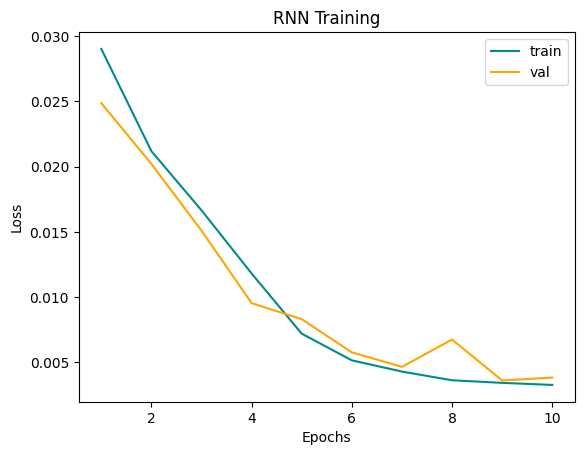

In [13]:
train_losses = training(rnn_classifier, train_loader, val_loader, 10, 4e-4, 'RNN Training')

In [14]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = rnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  1 ,  Italiano
Predicted Style:  1 with probability:  98.74022603034973 %
Input sequence: 
 ci veniva più la santuzza toccata nel debole non seppe più contenersi e gli disse che non ci veniva più


# RNN Classifier Accuracy

In [15]:
classifier_accuracy(rnn_classifier, style0_test, style1_test, style2_test, 'RNN')

Accuracy predicting Dante:  0.9695181907571289
Accuracy predicting Italian:  0.976401179941003
Accuracy predicting Neapolitan:  0.962
Overall  RNN  Accuracy:  0.9693064568993771


# GRU Classifier

In [16]:
gru_classifier = GRUClassifier(embedding_matrix, hidden_dim, 1)

In [17]:
classifier_params = sum(p.numel() for p in gru_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8067


 10%|█         | 1/10 [00:03<00:27,  3.00s/it]

====> Epoch: 1 Average train loss: 0.0251, Average val loss: 0.0165


 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

====> Epoch: 2 Average train loss: 0.0106, Average val loss: 0.0071


 30%|███       | 3/10 [00:09<00:21,  3.06s/it]

====> Epoch: 3 Average train loss: 0.0050, Average val loss: 0.0042


 40%|████      | 4/10 [00:12<00:19,  3.25s/it]

====> Epoch: 4 Average train loss: 0.0029, Average val loss: 0.0030


 50%|█████     | 5/10 [00:15<00:15,  3.20s/it]

====> Epoch: 5 Average train loss: 0.0019, Average val loss: 0.0023


 60%|██████    | 6/10 [00:18<00:12,  3.16s/it]

====> Epoch: 6 Average train loss: 0.0013, Average val loss: 0.0023


 70%|███████   | 7/10 [00:22<00:09,  3.30s/it]

====> Epoch: 7 Average train loss: 0.0009, Average val loss: 0.0020


 80%|████████  | 8/10 [00:25<00:06,  3.27s/it]

====> Epoch: 8 Average train loss: 0.0007, Average val loss: 0.0017


 90%|█████████ | 9/10 [00:29<00:03,  3.29s/it]

====> Epoch: 9 Average train loss: 0.0005, Average val loss: 0.0017


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]

====> Epoch: 10 Average train loss: 0.0004, Average val loss: 0.0018


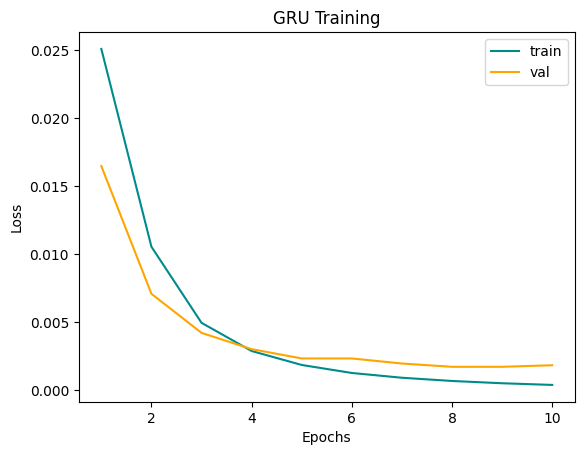

In [18]:
train_losses = training(gru_classifier, train_loader, val_loader, 10, 4e-4, 'GRU Training')

In [19]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = gru_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  1 ,  Italiano
Predicted Style:  1 with probability:  99.93222951889038 %
Input sequence: 
 e la longa ntoni ntoni ma voi altri ve la passate forse meglio di me a lavorare e ad affannarvi


# GRU Classifier Accuracy

In [20]:
classifier_accuracy(gru_classifier, style0_test, style1_test, style2_test, 'GRU')

Accuracy predicting Dante:  0.9626352015732547
Accuracy predicting Italian:  0.9911504424778761
Accuracy predicting Neapolitan:  0.99
Overall  GRU  Accuracy:  0.981261881350377


# LSTM Classifier

In [21]:
lstm_classifier = LSTMClassifier(embedding_matrix, hidden_dim, 1)

In [22]:
classifier_params = sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  10547


 10%|█         | 1/10 [00:01<00:14,  1.64s/it]

====> Epoch: 1 Average train loss: 0.0255, Average val loss: 0.0109


 20%|██        | 2/10 [00:03<00:12,  1.58s/it]

====> Epoch: 2 Average train loss: 0.0054, Average val loss: 0.0034


 30%|███       | 3/10 [00:04<00:10,  1.53s/it]

====> Epoch: 3 Average train loss: 0.0023, Average val loss: 0.0022


 40%|████      | 4/10 [00:06<00:09,  1.50s/it]

====> Epoch: 4 Average train loss: 0.0014, Average val loss: 0.0018


 50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

====> Epoch: 5 Average train loss: 0.0010, Average val loss: 0.0017


 60%|██████    | 6/10 [00:09<00:05,  1.49s/it]

====> Epoch: 6 Average train loss: 0.0008, Average val loss: 0.0017


 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

====> Epoch: 7 Average train loss: 0.0006, Average val loss: 0.0013


 80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

====> Epoch: 8 Average train loss: 0.0005, Average val loss: 0.0014


 90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

====> Epoch: 9 Average train loss: 0.0004, Average val loss: 0.0015


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]

====> Epoch: 10 Average train loss: 0.0003, Average val loss: 0.0014


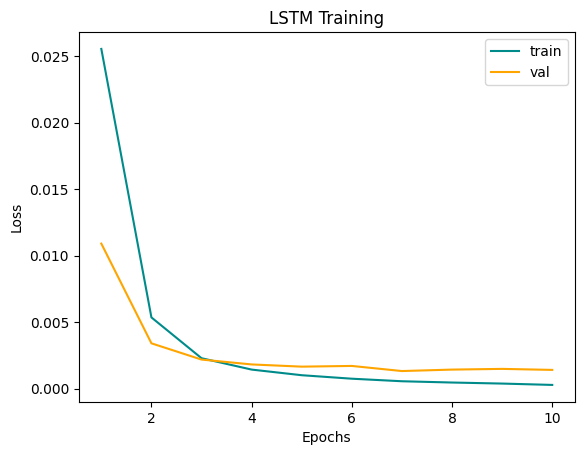

In [23]:
train_losses = training(lstm_classifier, train_loader, val_loader, 10, 4e-4, 'LSTM Training')

In [24]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = lstm_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.91732239723206 %
Input sequence: 
 scrivi pensa che pietro e paulo che moriro per la vigna che guasti ancor son vivi ben puoi tu dire


# LSTM Accuracy

In [25]:
classifier_accuracy(lstm_classifier, style0_test, style1_test, style2_test, 'LSTM')

Accuracy predicting Dante:  0.9793510324483776
Accuracy predicting Italian:  0.9941002949852508
Accuracy predicting Neapolitan:  0.994
Overall  LSTM  Accuracy:  0.9891504424778761


# Transformer Classifier

In [26]:
t_classifier = TClassifier(embedding_matrix)

In [27]:
classifier_params = sum(p.numel() for p in t_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3188599


 20%|██        | 1/5 [00:31<02:04, 31.13s/it]

====> Epoch: 1 Average train loss: 0.0011, Average val loss: 0.0009


 40%|████      | 2/5 [00:59<01:28, 29.37s/it]

====> Epoch: 2 Average train loss: 0.0003, Average val loss: 0.0010


 60%|██████    | 3/5 [01:30<01:00, 30.04s/it]

====> Epoch: 3 Average train loss: 0.0002, Average val loss: 0.0011


 80%|████████  | 4/5 [02:01<00:30, 30.68s/it]

====> Epoch: 4 Average train loss: 0.0001, Average val loss: 0.0010


100%|██████████| 5/5 [02:37<00:00, 31.42s/it]

====> Epoch: 5 Average train loss: 0.0001, Average val loss: 0.0009


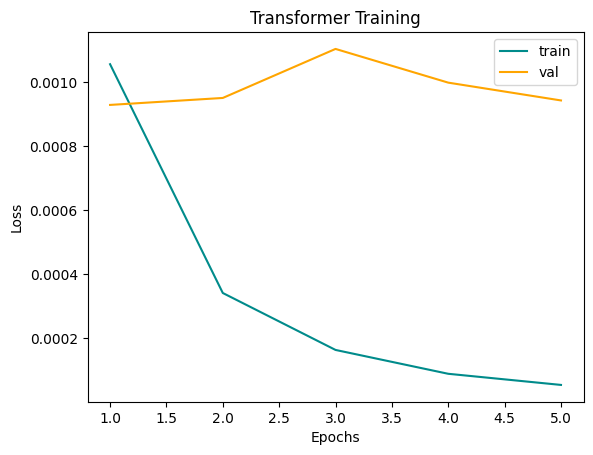

In [28]:
train_losses = training(t_classifier, train_loader, val_loader, 5, 4e-4, 'Transformer Training')

In [29]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = t_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  1 ,  Italiano
Predicted Style:  1 with probability:  99.99985694885254 %
Input sequence: 
 a don michele per farsi mangiare il resto come lo vedeva andare nella strada del nero credeva ci andasse per


# Transformer Classifier Accuracy

In [30]:
classifier_accuracy(t_classifier, style0_test, style1_test, style2_test, 'Transformer')

Accuracy predicting Dante:  0.9891838741396264
Accuracy predicting Italian:  0.9941002949852508
Accuracy predicting Neapolitan:  0.998
Overall  Transformer  Accuracy:  0.9937613897082924
